In [2]:
!pip install scikit-multilearn

import re
import os
import tqdm
import nltk
import pickle
import sqlite3
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from nltk.corpus import words
from datetime import datetime
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from itertools import combinations
from keras.models import load_model
from keras.models import Sequential
from tensorflow.keras import layers
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize
from keras.preprocessing import sequence
from scipy.sparse import coo_matrix, hstack
from tensorflow.keras.utils import plot_model
from keras.layers.embeddings import Embedding
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score,precision_score,recall_score,hamming_loss
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, LSTM, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization

%matplotlib inline
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings("ignore")
stemmer = SnowballStemmer('english')

%autosave 120

     |████████████████████████████████| 92kB 2.3MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Autosaving every 120 seconds


In [3]:
data = pd.read_csv("/content/drive/My Drive/ML/data_with_top_30.csv")
data.head(5)

,title,plot_synopsis,tags,split,synopsis_source,cnt_dup,tag_count,synopsis_count,synopsis_sent_count,CleanedSynopsis,absurd,action,adult comedy,allegory,alternate history,alternate reality,anti war,atmospheric,autobiographical,avant garde,blaxploitation,bleak,boring,brainwashing,christian film,claustrophobic,clever,comedy,comic,cruelty,cult,cute,dark,depressing,dramatic,entertaining,fantasy,feel-good,flashback,good versus evil,...,grindhouse film,haunting,historical,historical fiction,home movie,horror,humor,insanity,inspiring,intrigue,magical realism,melodrama,murder,mystery,neo noir,non fiction,paranormal,philosophical,plot twist,pornographic,prank,psychedelic,psychological,queer,realism,revenge,romantic,sadist,satire,sci-fi,sentimental,storytelling,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,imdb,1,1,648,26,set hamburg west germani sever crimin take adv...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,wikipedia,1,1,353,14,grader name griffin bing decid gather entir gr...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,wikipedia,1,4,699,39,gari hook new recruit british armi take leav m...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,wikipedia,1,2,665,41,sergeant dragon jacki chan part hong kong mari...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, violence, flashback, tragedy",train,wikipedia,1,6,1694,140,pretoria south africa major charl bolton rod m...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [0]:
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer = lambda x: str(x).split(", ") )
tag_vect = vectorizer.fit_transform(data["tags"])

In [5]:
tags = vectorizer.get_feature_names()
freqs = tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

[('action', 605), ('atmospheric', 385), ('boring', 519), ('comedy', 1795), ('cruelty', 422), ('cult', 2531), ('dark', 387), ('dramatic', 402), ('entertaining', 726), ('fantasy', 492), ('flashback', 2801), ('good versus evil', 793), ('gothic', 400), ('horror', 455), ('humor', 803), ('insanity', 585), ('melodrama', 423), ('murder', 5375), ('mystery', 500), ('neo noir', 700), ('paranormal', 501), ('psychedelic', 1800), ('revenge', 2313), ('romantic', 2729), ('sadist', 618), ('satire', 780), ('storytelling', 346), ('suspenseful', 1026), ('tragedy', 536), ('violence', 4138)]


In [6]:
tag_counts = pd.DataFrame(result,columns=['tag','tag_counts'])
tag_counts.head()

,tag,tag_counts
0,action,605
1,atmospheric,385
2,boring,519
3,comedy,1795
4,cruelty,422


In [0]:
tag_counts_sorted = tag_counts.sort_values(['tag_counts'], ascending=False)

In [8]:
tag_counts = tag_counts_sorted['tag'][:5]
tag_counts

17       murder
29     violence
10    flashback
23     romantic
5          cult
Name: tag, dtype: object

In [0]:
tags_5 = list(tag_counts)

In [10]:
data['tags']

0                                                   murder
1                                                flashback
2                  suspenseful, neo noir, murder, violence
3                                           cult, violence
4                     murder, violence, flashback, tragedy
                               ...                        
13005                            comedy, sadist, flashback
13006                                   paranormal, murder
13007                                             romantic
13008    cruelty, murder, cult, violence, flashback, ps...
13009                                               murder
Name: tags, Length: 13010, dtype: object

In [11]:
#Deleting Every Tags other than TOP 5 Tags

for le in tqdm(range(data.shape[0])):
    a = []
    b = data['tags'][le].split(",")
    c = ''
    
    for i in range(len(b)):        
        for j in tags_5:
            temp = b[i].strip()  #Stripping the white-spaces present(if any) around the tag
            
            if temp == j:        #Comparing with the TOP 5 tags
                a.append(j)
        
    if a:
        data['tags'][le] = ", ".join(a)
    else:
         data['tags'][le] = np.nan        

100%|██████████| 13010/13010 [00:02<00:00, 5894.90it/s]


In [0]:
#Deleting the rows that have NaN Values
data = data.dropna() 

In [13]:
data['tags']

0                                   murder
1                                flashback
2                         murder, violence
3                           cult, violence
4              murder, violence, flashback
                       ...                
13005                            flashback
13006                               murder
13007                             romantic
13008    murder, cult, violence, flashback
13009                               murder
Name: tags, Length: 10282, dtype: object

In [0]:
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer = lambda x: str(x).split(", "))
tag_vect = vectorizer.fit_transform(data["tags"])

In [15]:
tags = vectorizer.get_feature_names()
freqs = tag_vect.sum(axis=0).A1
result = list(zip(tags, freqs))

print((result))

[('cult', 2531), ('flashback', 2801), ('murder', 5375), ('romantic', 2729), ('violence', 4138)]


In [16]:
len(result)

5

In [0]:
conn = sqlite3.connect('data05.db')
data.to_sql('data05', conn, if_exists='replace', index=False)
train = pd.read_sql("Select * From data05 where split = 'train' OR split='val'",conn)
test =  pd.read_sql("Select * From data05 where split = 'test'",conn)
conn.close()

In [0]:
X_train = train["CleanedSynopsis"]
y_train= train["tags"]

X_test = test["CleanedSynopsis"]
y_test= test["tags"]

In [0]:
cnt_vectorizer = CountVectorizer(binary='true', max_features = 30).fit(y_train)
y_train_multilabel = cnt_vectorizer.transform(y_train)
y_test_multilabel = cnt_vectorizer.transform(y_test)

In [20]:
print("Dimensions of data Y_train_multilabel:",y_train_multilabel.shape,"Y_test_multilabel:",y_test_multilabel.shape)

Dimensions of data Y_train_multilabel: (8205, 5) Y_test_multilabel: (2077, 5)


# Word2Vec

In [21]:
X_train_new = []

for i in tqdm(range(len(list(X_train)))):
    X_train_new.append(X_train[i].split(" "))

100%|██████████| 8205/8205 [00:00<00:00, 17455.20it/s]


In [0]:
with open('/content/drive/My Drive/ML/glove.6B.300d.pkl', 'rb') as f:
    new_model = pickle.load(f)
    words =  set(new_model.keys())

In [23]:
X_train_multilabel = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train.values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split():
        if word in words:
            vector += new_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_multilabel.append(vector)

100%|██████████| 8205/8205 [00:06<00:00, 1208.03it/s]


In [24]:
X_test_multilabel = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test.values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split():
        if word in words:
            vector += new_model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_multilabel.append(vector)

100%|██████████| 2077/2077 [00:01<00:00, 1334.30it/s]


<h1>OneVsRestClassifier + SGDClassifier with LOG Loss :</h1>

In [25]:
sgl = SGDClassifier(loss='log', class_weight='balanced')

clf = OneVsRestClassifier(sgl)
clf.fit(X_train_multilabel, y_train_multilabel)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal', loss='log',
                                            max_iter=1000, n_iter_no_change=5,
                                            n_jobs=None, penalty='l2',
                                            power_t=0.5, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                    n_jobs=None)

In [26]:
prediction1 = clf.predict(X_test_multilabel)

precision1 = precision_score(y_test_multilabel, prediction1, average='micro')

recall1 = recall_score(y_test_multilabel, prediction1, average='micro')

f1_score1 = 2*((precision1 * recall1)/(precision1 + recall1))

print("precision1: {:.4f}, recall1: {:.4f}, F1-measure: {:.4f}".format(precision1, recall1, f1_score1))

precision1: 0.5382, recall1: 0.6682, F1-measure: 0.5962


In [27]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ",y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(prediction1[k])[0],"\n")

Movie:  Cain's Cutthroats
Actual genre:  murder, violence
Predicted tag:  ['murder' 'violence'] 

Movie:  The Sugarland Express
Actual genre:  violence
Predicted tag:  ['cult' 'murder'] 

Movie:  The Dark Crystal
Actual genre:  cult
Predicted tag:  ['romantic'] 

Movie:  Kozure Ôkami: Shinikazeni mukau ubaguruma
Actual genre:  violence
Predicted tag:  ['cult' 'murder' 'violence'] 

Movie:  Uno dopo l'altro
Actual genre:  violence
Predicted tag:  ['cult' 'violence'] 



<h2> OneVsRestClassifier + SGDClassifier with HINGE Loss : </h2>

In [28]:
sgh = SGDClassifier(loss='hinge', class_weight='balanced')

clf = OneVsRestClassifier(sgh)
clf.fit(X_train_multilabel, y_train_multilabel)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [29]:
prediction2 = clf.predict(X_test_multilabel)

precision2 = precision_score(y_test_multilabel, prediction2, average='micro')

recall2 = recall_score(y_test_multilabel, prediction2, average='micro')

f1_score2 = 2*((precision2 * recall2)/(precision2 + recall2))

print("precision2: {:.4f}, recall2: {:.4f}, F1-measure: {:.4f}".format(precision2, recall2, f1_score2))

precision2: 0.5762, recall2: 0.5516, F1-measure: 0.5636


In [30]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ",y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(prediction2[k])[0],"\n")

Movie:  Blindness
Actual genre:  murder, violence
Predicted tag:  ['murder'] 

Movie:  Mommy
Actual genre:  violence, murder
Predicted tag:  ['romantic'] 

Movie:  Walking Tall Part II
Actual genre:  murder, violence
Predicted tag:  ['murder' 'violence'] 

Movie:  I Me Wed
Actual genre:  romantic
Predicted tag:  ['romantic'] 

Movie:  The Pirate
Actual genre:  cult, romantic
Predicted tag:  ['romantic'] 



<h2> OneVsRestClassifier + LogisticRegression:</h2>

In [31]:
lr = LogisticRegression(class_weight='balanced')

clf = OneVsRestClassifier(lr)
clf.fit(X_train_multilabel, y_train_multilabel)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [32]:
prediction3 = clf.predict(X_test_multilabel)

precision3 = precision_score(y_test_multilabel, prediction3, average='micro')

recall3 = recall_score(y_test_multilabel, prediction3, average='micro')

f1_score3 = 2*((precision3 * recall3)/(precision3 + recall3))

print("precision3: {:.4f}, recall3: {:.4f}, F1-measure: {:.4f}".format(precision3, recall3, f1_score3))

precision3: 0.5247, recall3: 0.6748, F1-measure: 0.5904


In [33]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ",y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(prediction3[k])[0],"\n")

Movie:  Bandido
Actual genre:  violence
Predicted tag:  ['cult' 'flashback' 'murder' 'violence'] 

Movie:  Crouching Tiger, Hidden Dragon: Sword of Destiny
Actual genre:  romantic
Predicted tag:  ['cult' 'violence'] 

Movie:  Men, Women & Children
Actual genre:  violence
Predicted tag:  ['flashback' 'romantic'] 

Movie:  Rockstar
Actual genre:  romantic
Predicted tag:  ['romantic'] 

Movie:  Kaze no na wa amunejia
Actual genre:  violence, romantic
Predicted tag:  ['romantic'] 



<h1>Conclusion</h1>

In [34]:
from prettytable import PrettyTable

tabel = PrettyTable()

tabel.field_names=['Model', 'Vectorizer', 'Precision','recall','f1_score']


tabel.add_row(['SGDClassifier(log)', 'AVG W2V',  round(precision1, 3), round(recall1, 3), round(f1_score1, 3)])

tabel.add_row(['SGDClassifier(hinge)','AVG W2V', round(precision2, 3),  round(recall2, 3), round(f1_score2, 3)])

tabel.add_row(['LogisticRegression','AVG W2V', round(precision3, 3), round(recall3, 3), round(f1_score3, 3)])


print(tabel)

+----------------------+------------+-----------+--------+----------+
|        Model         | Vectorizer | Precision | recall | f1_score |
+----------------------+------------+-----------+--------+----------+
|  SGDClassifier(log)  |  AVG W2V   |   0.538   | 0.668  |  0.596   |
| SGDClassifier(hinge) |  AVG W2V   |   0.576   | 0.552  |  0.564   |
|  LogisticRegression  |  AVG W2V   |   0.525   | 0.675  |   0.59   |
+----------------------+------------+-----------+--------+----------+


<h1>LSTM-CNN Model</h1>

In [0]:
max_review_length = 400
X_train = sequence.pad_sequences(X_train_multilabel, maxlen=max_review_length, padding='post')
X_test = sequence.pad_sequences(X_test_multilabel, maxlen=max_review_length, padding='post')

In [0]:
inputt = 8252
batch_size = 60
epochs = 20

In [0]:
tf.random.set_seed(100)

tf.keras.backend.clear_session()

In [38]:
model = Sequential()
model.add(Embedding(inputt, 50, input_length = max_review_length))

model.add(LSTM(300, return_sequences=True))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(5, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           412600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 300)          421200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 400, 200)          400800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 1,355,505
Trainable params: 1,355,505
Non-trainable params: 0
____________________________________________

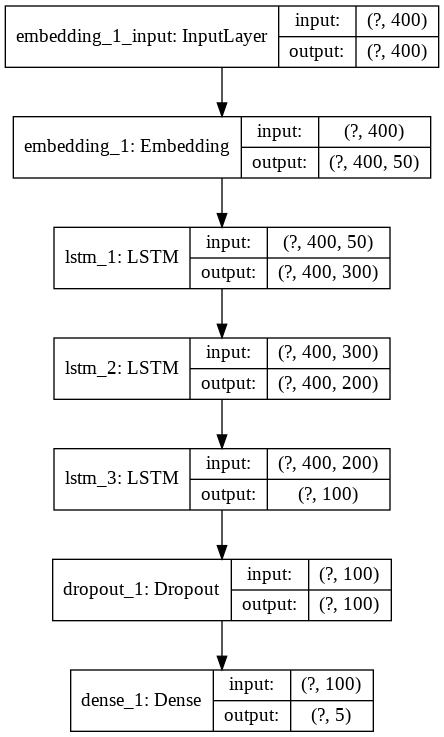

In [39]:
plot_model(model, 'model.png', show_shapes=True)

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model.fit(X_train, y_train_multilabel, 
          batch_size = batch_size,
          validation_data=(X_test, y_test_multilabel),
          epochs=epochs)

Train on 8205 samples, validate on 2077 samples
Epoch 1/20
8205/8205 [==============================] - 303s 37ms/step - loss: 0.6211 - accuracy: 0.6643 - val_loss: 0.6233 - val_accuracy: 0.6629
Epoch 2/20
8205/8205 [==============================] - 285s 35ms/step - loss: 0.6184 - accuracy: 0.6665 - val_loss: 0.6218 - val_accuracy: 0.6629
Epoch 3/20
8205/8205 [==============================] - 254s 31ms/step - loss: 0.6182 - accuracy: 0.6678 - val_loss: 0.6226 - val_accuracy: 0.6547
Epoch 4/20
8205/8205 [==============================] - 258s 31ms/step - loss: 0.6181 - accuracy: 0.6654 - val_loss: 0.6217 - val_accuracy: 0.6629
Epoch 5/20
8205/8205 [==============================] - 257s 31ms/step - loss: 0.6179 - accuracy: 0.6672 - val_loss: 0.6209 - val_accuracy: 0.6629
Epoch 6/20
8205/8205 [==============================] - 251s 31ms/step - loss: 0.6179 - accuracy: 0.6674 - val_loss: 0.6213 - val_accuracy: 0.6629
Epoch 7/20
8205/8205 [==============================] - 244s 30ms/step

In [42]:
test_loss, test_acc = model.evaluate(X_test, y_test_multilabel, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.662879228591919


In [0]:
model.save('lstm_model_manual5.h5') #Saving the Model for Future Use

In [0]:
model = load_model('lstm_model_manual5.h5') #Loading the Model

In [0]:
model_prediction = model.predict(X_test, verbose=0)

In [46]:
for i in range(5):
    k = test.sample(1).index[0]
    print("Movie: ", test['title'][k]) 
    print("Actual genre: ", y_test[k])
    print("Predicted tag: ", cnt_vectorizer.inverse_transform(model_prediction[k])[0],"\n")

Movie:  Merantau
Actual genre:  violence
Predicted tag:  ['cult' 'flashback' 'murder' 'romantic' 'violence'] 

Movie:  Hearts in Atlantis
Actual genre:  flashback
Predicted tag:  ['cult' 'flashback' 'murder' 'romantic' 'violence'] 

Movie:  2 Guns
Actual genre:  murder, violence, flashback, romantic
Predicted tag:  ['cult' 'flashback' 'murder' 'romantic' 'violence'] 

Movie:  The Karate Kid
Actual genre:  cult, violence
Predicted tag:  ['cult' 'flashback' 'murder' 'romantic' 'violence'] 

Movie:  American Ninja 5
Actual genre:  murder, violence, flashback
Predicted tag:  ['cult' 'flashback' 'murder' 'romantic' 'violence'] 

